In [ ]:
# Clean data

import pandas as pd
import numpy as np

df = pd.read_csv('Stocks_MergedSentiments_Combined.csv')

# Convert daily_return to numeric
df['daily_return'] = pd.to_numeric(df['daily_return'], errors='coerce')

# Drop rows with missing daily_return or sentiment
df = df.dropna(subset=['daily_return', 'news_score', 'twitter_score'])

# Remove rows where both twitter and news sentiment are neutral
df = df[~((df['twitter_score'] == 0) & (df['news_score'] == 0))]

# Confirm shape
print("Shape after filtering:", df.shape)

df.head(10)

Shape after filtering: (9583, 15)


,date,ticker,price,volume,daily_return,dividend,low_bid,high_ask,sp500_return,news_score,twitter_score,final_sentiment_score,sentiment_1d,sentiment_3d_avg,sentiment_7d_avg
3,03/10/2022,ORCL,76.65,13812596.0,0.007227,NaN,75.030,76.8500,-0.004292,-1.000000,0.000000,-0.650000,0.320458,-0.109847,0.064069
7,06/13/2022,ORCL,64.05,16547246.0,-0.046023,NaN,63.760,66.1000,-0.038768,1.000000,0.000000,0.650000,0.325000,0.325000,0.169556
9,06/16/2022,ORCL,68.71,10685987.0,-0.014204,NaN,67.580,68.9600,-0.032512,0.000000,0.412748,0.144462,0.000000,0.178154,0.215637
11,07/27/2022,ORCL,75.87,6677226.0,0.024855,NaN,74.320,76.1200,0.026156,0.000000,0.520375,0.182131,0.000000,0.166685,0.224635
13,09/12/2022,ORCL,77.08,15628850.0,0.015413,NaN,76.270,77.3771,0.010584,-0.497464,0.000000,-0.323352,0.000000,-0.107784,0.019205
16,12/12/2022,ORCL,81.28,15807550.0,0.017781,NaN,79.935,81.4100,0.014279,0.500000,0.000000,0.325000,0.162499,0.162500,0.080679
18,12/19/2022,ORCL,80.50,7738813.0,0.011561,NaN,79.680,81.1000,-0.009007,0.000000,0.471924,0.165173,0.000000,0.072819,-0.014236
24,03/10/2023,ORCL,84.07,16029345.0,-0.032232,NaN,82.880,85.2500,-0.014478,-0.999994,0.000000,-0.649996,-0.650000,-0.326512,-0.028787
25,03/24/2023,ORCL,88.01,5852248.0,0.002620,NaN,87.510,88.4800,0.005640,0.999989,0.000000,0.649993,0.185931,0.278641,-0.066282
27,05/17/2023,ORCL,99.77,9436009.0,0.015471,NaN,98.430,100.4000,0.011891,0.000000,0.664784,0.232674,0.000000,0.077558,0.218953


In [ ]:
# install deps
#!pip install -q imbalanced-learn xgboost scikit-optimize

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from imblearn.combine import SMOTETomek
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from skopt.space import Real, Integer
from skopt import BayesSearchCV


# Label Buy/Hold/Sell at ±1.2% daily_return threshold ---
TH = 0.012
df['daily_return'] = df['daily_return'].astype(float)
df['action'] = np.where(df['daily_return']>=TH,'Buy',
                np.where(df['daily_return']<=-TH,'Sell','Hold'))

In [ ]:
# new tech features:
df['ret3'] = (df.groupby('ticker')['daily_return']
                .rolling(3, min_periods=1).sum()
                .reset_index(0,drop=True))
df['vol7'] = (df.groupby('ticker')['daily_return']
                .rolling(7, min_periods=1).std()
                .reset_index(0,drop=True)).fillna(0)
df['vma7'] = (df.groupby('ticker')['volume']
                .rolling(7, min_periods=1).mean()
                .reset_index(0,drop=True))
df['bidask_spread'] = df['high_ask'] - df['low_bid']

In [ ]:
# Select features & drop NA/action-less rows ---
base_feats = [
  'price','volume','low_bid','high_ask','sp500_return',
  'news_score','twitter_score','final_sentiment_score',
  'sentiment_1d', 'sentiment_3d_avg', 'sentiment_7d_avg'
]
extra_feats = ['ret3','vol7','vma7','bidask_spread']
all_feats = base_feats + extra_feats

model_df = df.dropna(subset=all_feats+['action'])

In [ ]:
# Encode target & train/test split (80/20 stratified) ---
le = LabelEncoder()
model_df['y'] = le.fit_transform(model_df['action'])

X_train, X_test, y_train, y_test = train_test_split(
    model_df[all_feats], model_df['y'],
    test_size=0.2, stratify=model_df['y'], random_state=42
)

<ipython-input-14-6cc0e06c6be5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df['y'] = le.fit_transform(model_df['action'])


In [ ]:
# Balance training set ---
smt = SMOTETomek(random_state=42)
X_res, y_res = smt.fit_resample(X_train, y_train)

In [ ]:
# Bayesian hyperparameter search over XGB ---
search_space = {
    'max_depth': Integer(3,10),
    'learning_rate': Real(0.01,0.3,'log-uniform'),
    'n_estimators': Integer(100,500),
    'subsample': Real(0.6,1.0),
    'colsample_bytree': Real(0.6,1.0),
    'gamma': Real(0,5),
    'reg_alpha': Real(0,1),
    'reg_lambda': Real(1,10)
}

bayes_cv = BayesSearchCV(
    XGBClassifier(objective='multi:softprob', use_label_encoder=False,
                  eval_metric='mlogloss', n_jobs=-1, random_state=42),
    search_space,
    n_iter=30, cv=3, scoring='accuracy',
    random_state=42, verbose=0
)

bayes_cv.fit(X_res, y_res)
best = bayes_cv.best_params_
print("Best Params:", best)

In [ ]:
# Evaluate best estimator ---
model = bayes_cv.best_estimator_
y_pred = model.predict(X_test)

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, target_names=le.classes_))
print("\n=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))


=== Classification Report ===
              precision    recall  f1-score   support

         Buy       0.69      0.74      0.72       516
        Hold       0.76      0.69      0.72       911
        Sell       0.64      0.71      0.67       472

    accuracy                           0.71      1899
   macro avg       0.70      0.71      0.70      1899
weighted avg       0.71      0.71      0.71      1899


=== Confusion Matrix ===
[[382  96  38]
 [134 626 151]
 [ 36 103 333]]


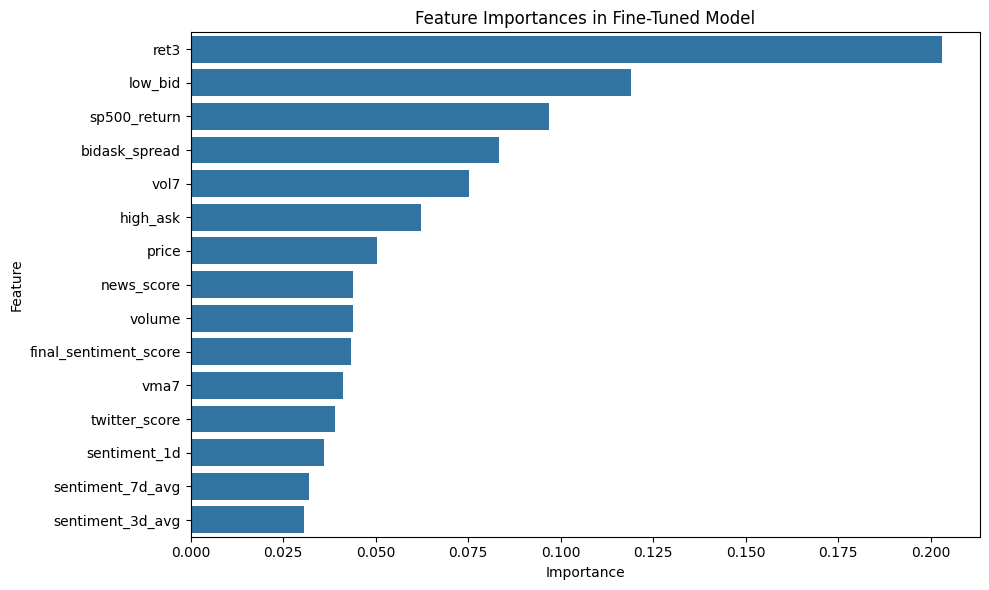

In [ ]:
# Visualize Feature Importance
import matplotlib.pyplot as plt
import seaborn as sns

importances = model.feature_importances_
features = all_feats
feat_imp_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df)
plt.title('Feature Importances in Fine-Tuned Model')
plt.tight_layout()
plt.show()

In [ ]:
# Save model

import joblib
joblib.dump(bayes_cv.best_estimator_, "final_xgb_model.pkl")

joblib.dump(le, "label_encoder.pkl")

import json
with open("feature_list.json", "w") as f:
    json.dump(all_feats, f)

In [24]:
# Save model vs actual predictions of actions
from sklearn.metrics import classification_report


predicted_labels = model.predict(X_test)
predicted_classes = le.inverse_transform(predicted_labels)
actual_classes = le.inverse_transform(y_test)

# Add actual and predicted to X_test
sample_df = X_test.copy()
sample_df['Actual_Action'] = actual_classes
sample_df['Predicted_Action'] = predicted_classes

# Join back ticker info from model_df
sample_df['ticker'] = model_df.loc[X_test.index, 'ticker'].values
sample_df['final_sentiment_score'] = model_df.loc[X_test.index, 'final_sentiment_score'].values

# S&P 500 ticker popular stocks list
sp500_tickers = ['AAPL', 'MSFT', 'TSLA', 'AMZN', 'GOOGL', 'META', 'NVDA', 'JPM', 'NFLX', 'ORCL']

# Filter to include known S&P 500 tickers
sp_sample = sample_df[sample_df['ticker'].isin(sp500_tickers)]

sp_part = sp_sample.sample(n=min(25, len(sp_sample)), random_state=42)
non_sp_part = sample_df[~sample_df.index.isin(sp_part.index)].sample(n=100 - len(sp_part), random_state=42)

final_sample = pd.concat([sp_part, non_sp_part]).sort_index()

In [26]:
# Keeping only important columns
trimmed_sample = final_sample[['ticker', 'price', 'final_sentiment_score',
 'sentiment_7d_avg', 'sentiment_3d_avg', 'ret3', 'sp500_return',
 'Actual_Action', 'Predicted_Action']
]

# Round numeric values for readability
trimmed_sample['price'] = trimmed_sample['price'].round(2)
trimmed_sample['final_sentiment_score'] = trimmed_sample['final_sentiment_score'].round(3)
trimmed_sample['sentiment_7d_avg'] = trimmed_sample['sentiment_7d_avg'].round(3)
trimmed_sample['sentiment_3d_avg'] = trimmed_sample['sentiment_3d_avg'].round(3)
trimmed_sample['ret3'] = trimmed_sample['ret3'].round(3)
trimmed_sample['sp500_return'] = trimmed_sample['sp500_return'].round(3)

# Save
trimmed_sample.to_csv("Actual_vs_Predictions.csv", index=False)


<ipython-input-26-7ee1bbed32a7>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trimmed_sample['price'] = trimmed_sample['price'].round(2)
<ipython-input-26-7ee1bbed32a7>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trimmed_sample['final_sentiment_score'] = trimmed_sample['final_sentiment_score'].round(3)
<ipython-input-26-7ee1bbed32a7>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats